In [17]:
## load libraries
suppressWarnings(suppressPackageStartupMessages(library(ggthemes)))
suppressWarnings(suppressPackageStartupMessages(library(ggplot2)))
suppressWarnings(suppressPackageStartupMessages(library(scran)))
suppressWarnings(suppressPackageStartupMessages(library(cowplot)))

In [5]:
col_day0 = canva_pal("Pool party")(4)[1]
col_day1 = canva_pal("Pool party")(4)[2]
col_day2 = canva_pal("Pool party")(4)[3]
col_day3 = canva_pal("Pool party")(4)[4]

col_ips = canva_pal("Modern and clean")(4)[2]
col_mesendo = canva_pal("Modern and clean")(4)[4]
col_defendo = canva_pal("Warm tones")(4)[3]

In [2]:
# load sceset
sce = readRDS("/hps/nobackup/hipsci/scratch/singlecell_endodiff/data_processed/merged/20180618/sce_merged_afterqc_filt_allexpts.rds")

In [3]:
sce

class: SingleCellExperiment 
dim: 11231 36044 
metadata(4): log.exprs.offset log.exprs.offset log.exprs.offset
  log.exprs.offset
assays(3): tpm counts logcounts
rownames(11231): ENSG00000000003_TSPAN6 ENSG00000000419_DPM1 ...
  ENSG00000272325_NUDT3 ENSG00000272398_CD24
rowData names(17): exprs_collapsed_to ensembl_transcript_id ...
  is_intop2000hvg is_hvg
colnames(36044): 21843_1#10 21843_1#100 ... 24539_8#97 24539_8#98
colData names(123): adj_x adj_y ... princ_curve princ_curve_scaled01
reducedDimNames(1): PCA
spikeNames(1): ERCC

In [4]:
# normalize
sce <- normalize(sce)
# define design matrix with batch structure (experiment)
design <- model.matrix(~experiment, data = colData(sce))
# define highly variable genes
alt.fit <- trendVar(sce, design = design, use.spikes = FALSE)
alt.decomp <- decomposeVar(sce, alt.fit)

Warning message in .local(object, ...):
“spike-in transcripts in 'ERCC' should have their own size factors”

In [6]:
# get top 500
top.500.hvgs <- rownames(alt.decomp[order(alt.decomp$bio, decreasing = TRUE),][1:500,])

In [21]:
# get PC1 from expression of the top 500 hvgs
sce_500hvg = sce[rownames(sce) %in% top.500.hvgs,]
p1 = as.data.frame(prcomp(t(logcounts(sce_500hvg)))$x[,1])
colnames(p1) = "PC1_top500hvgs"
head(p1)

,PC1_top500hvgs
21843_1#10,-11.7695261
21843_1#100,5.1315308
21843_1#101,-0.6430211
21843_1#102,-14.5080208
21843_1#103,-5.8029849
21843_1#105,-2.3442226


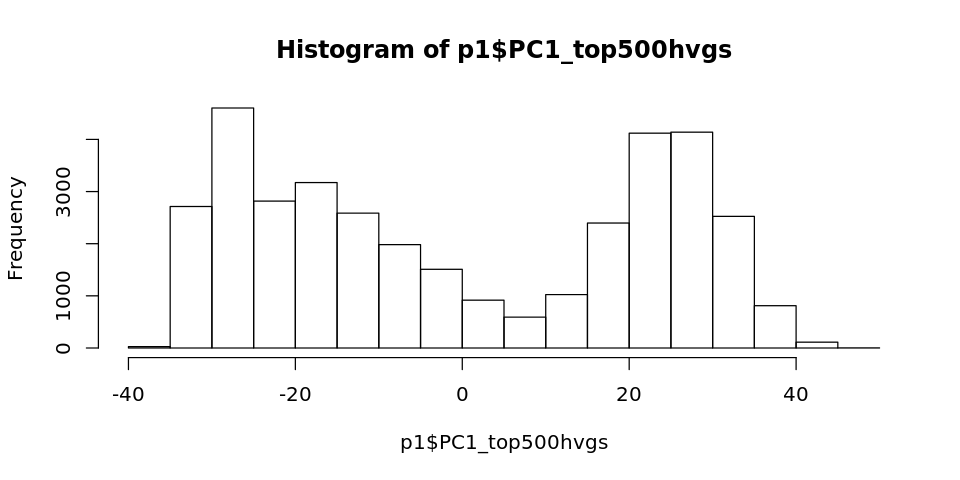

In [22]:
# use as pseudotime
options(repr.plot.width = 8, repr.plot.height = 4) 
hist(p1$PC1_top500hvgs)

In [23]:
range01 <- function(x){(x-min(x))/(max(x)-min(x))}

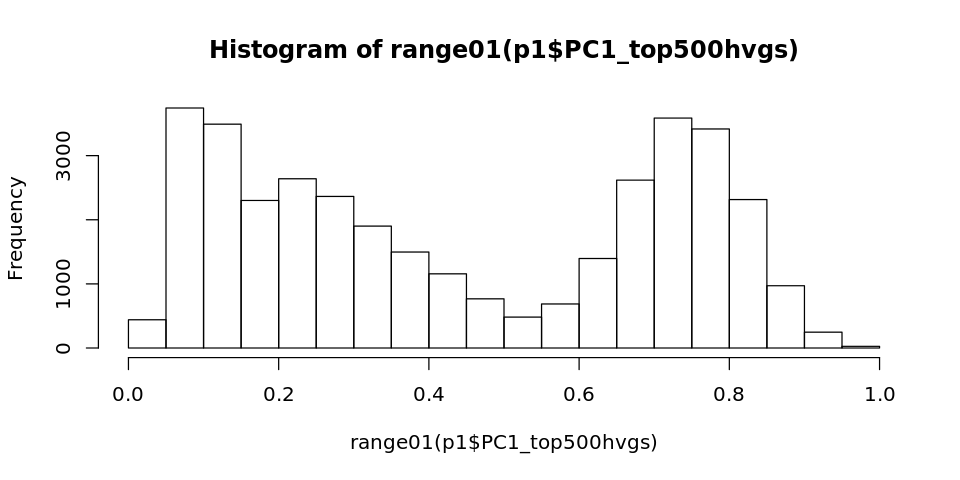

In [24]:
hist(range01(p1$PC1_top500hvgs))

In [25]:
###########################################
######## plot marker genes along pseudotime 
######## Figure 1D

In [26]:
diff_genes_reduced = c("ENSG00000111704_NANOG", "ENSG00000164458_T", "ENSG00000163508_EOMES", "ENSG00000141448_GATA6")

In [27]:
sce$pseudotime = p1$PC1_top500hvgs
s = sce$pseudotime
df = data.frame(cell = sce$cell_name, day = sce$day, expt = sce$experiment, donor = sce$donor) 
df$pseudo = range01(s)
head(df)

cell,day,expt,donor,pseudo
21843_1#10,day1,expt_09,joxm,0.3022399
21843_1#100,day1,expt_09,fafq,0.5042794
21843_1#101,day1,expt_09,fafq,0.4352490
21843_1#102,day1,expt_09,wuye,0.2695033
21843_1#103,day1,expt_09,joxm,0.3735655
21843_1#105,day1,expt_09,iisa,0.4149124


In [28]:
plist = list()
for (i in 1:length(diff_genes_reduced)){
    gene = diff_genes_reduced[i]
    df$gene = logcounts(sce)[gene,]
    plist[[i]] = ggplot(df, aes(x = as.numeric(pseudo), y = as.numeric(gene), colour = as.factor(day))) + 
            geom_point(alpha = 0.2, pch = 20) 
}

`geom_smooth()` using method = 'gam'
`geom_smooth()` using method = 'gam'
`geom_smooth()` using method = 'gam'
`geom_smooth()` using method = 'gam'


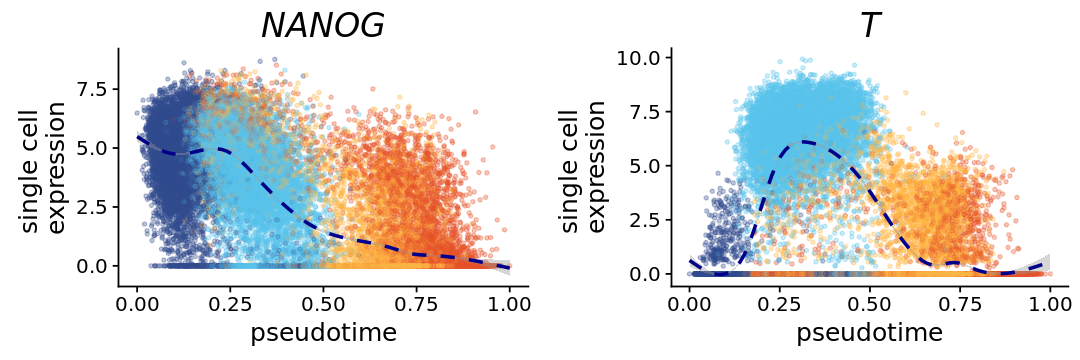

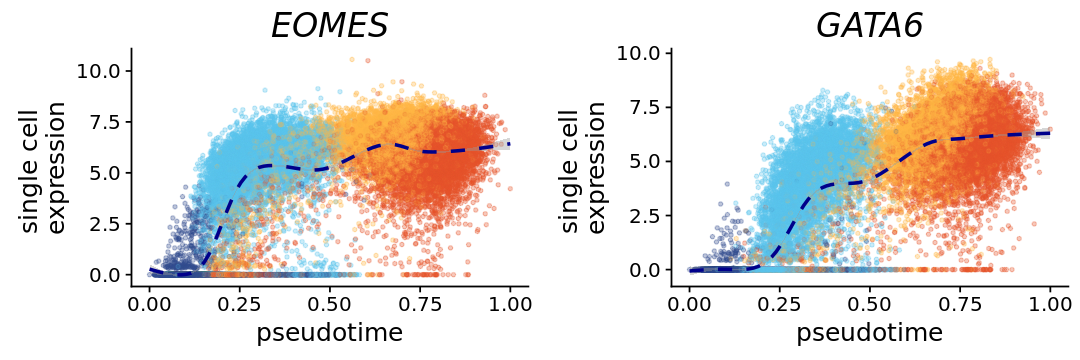

In [29]:
options(repr.plot.width = 9, repr.plot.height = 3) 
plist = plist
for (j in seq(2, length(diff_genes_reduced), by = 2)){
    p1 = plist[[j-1]]
    p1 = p1 + ggtitle(gsub(".*_","",diff_genes_reduced[j-1])) + 
         xlab("pseudotime") + ylab("single cell \nexpression") + labs(colour = "day") + 
        scale_color_canva(palette = "Pool party") + geom_point(alpha = 0.15, pch = 20) +
        stat_smooth(colour = "darkblue", linetype = 2) +  
        theme(legend.position="none", panel.border = element_blank(), text = element_text(size = 15))+
        theme(plot.title = element_text(face = "italic", size = 20))
    p2 = plist[[j]]
    p2 = p2 + ggtitle(gsub(".*_","",diff_genes_reduced[j])) + 
        xlab("pseudotime") + ylab("single cell \nexpression") + labs(colour = "day") + 
        scale_color_canva(palette = "Pool party") + geom_point(alpha = 0.15, pch = 20) +
        stat_smooth(colour = "darkblue", linetype = 2) + 
        theme(legend.position="none", panel.border = element_blank(), text = element_text(size = 15)) +
        theme(plot.title = element_text(face = "italic", size = 20))
    print(plot_grid(p1, p2, ncol = 2))
}

In [13]:
#############################################
######## define pseudotime - inferred stages
######## Figure S8

`geom_smooth()` using method = 'gam'


`geom_smooth()` using method = 'gam'


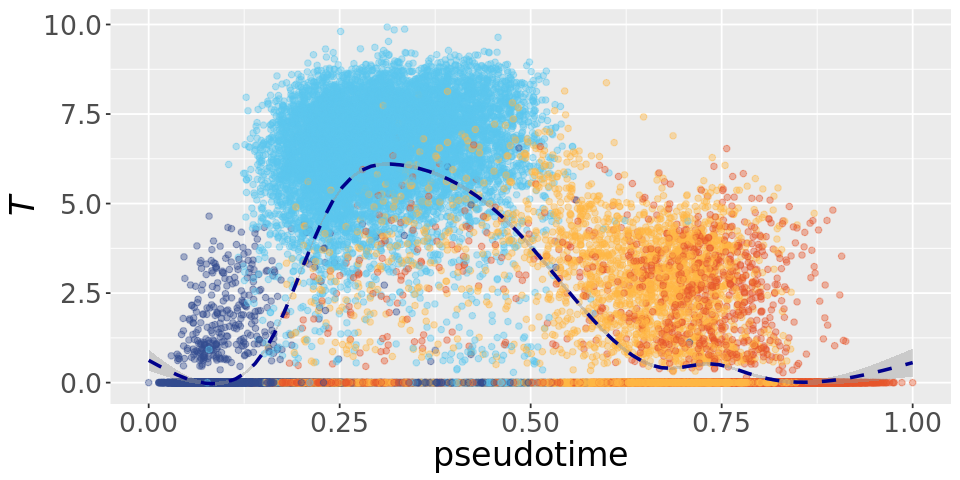

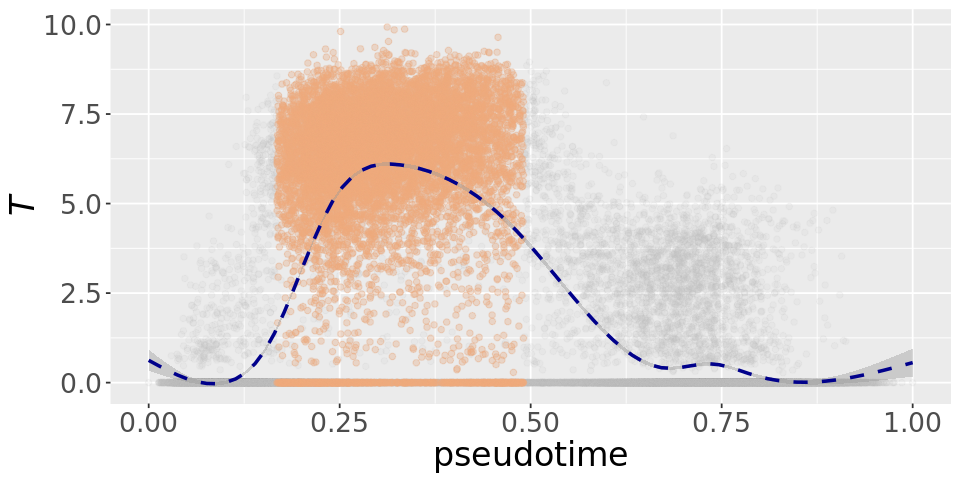

In [11]:
# plot stage definition : mesendo
df = cbind(p1, logcounts(sce)["ENSG00000164458_T",], sce$day)
colnames(df) = c("pseudotime","T","day")
df$scaled_pseudo <- range01(df$pseudotime)

options(repr.plot.width = 8, repr.plot.height = 4) 
ggplot(df, aes(x = scaled_pseudo, y = T, colour = day)) +
        geom_point(alpha = 0.4)  + xlab("pseudotime") +
        scale_color_canva(palette = "Pool party") + 
        stat_smooth(colour = "darkblue", linetype = 2) + theme(text = element_text(size = 20)) +
        theme(legend.position = "none") + theme(axis.title.y = element_text(face = "italic", size = 20))
ggplot(df, aes(x = scaled_pseudo, y = T, colour = day))  + 
        geom_point(alpha = 0.1, col = "grey")  + xlab("pseudotime") +
#         scale_color_canva(palette = "Pool party") + 
        geom_point(aes(x = scaled_pseudo, y = T), colour = col_mesendo,
               data = dplyr::filter(df, pseudotime > -23 & pseudotime < 4, day %in% c("day1","day2")),
                  alpha = 0.3) + theme(text = element_text(size = 20)) +
        theme(axis.title.y = element_text(face = "italic", size = 20)) + 
        stat_smooth(colour = "darkblue", linetype = 2) 

`geom_smooth()` using method = 'gam'


`geom_smooth()` using method = 'gam'


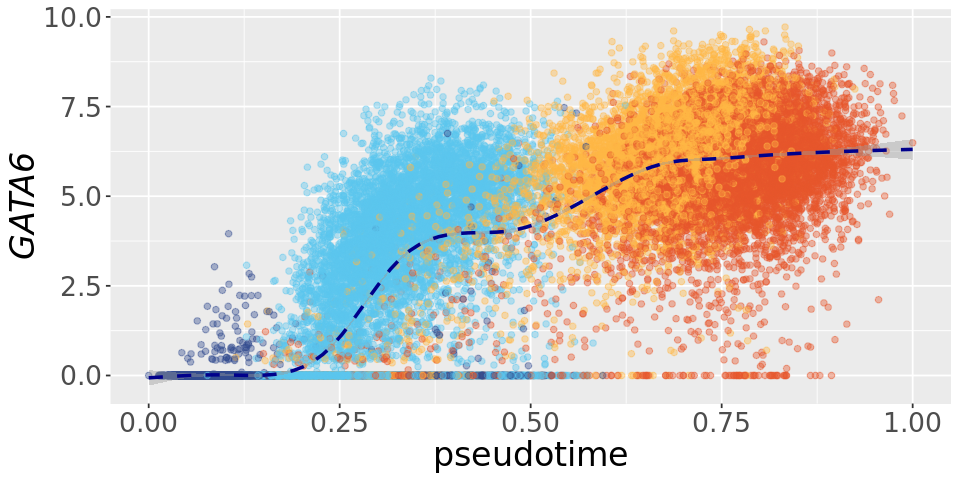

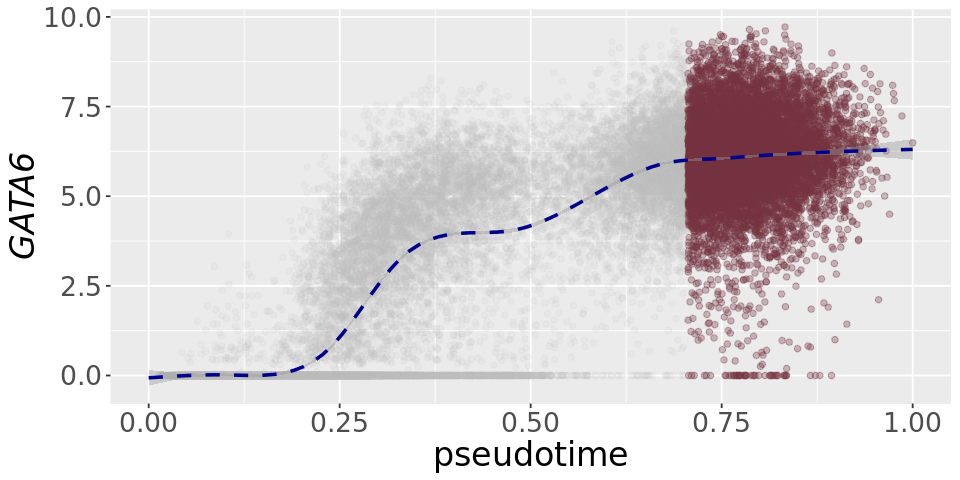

In [12]:
# plot stage definition : defendo
df = cbind(p1, logcounts(sce)["ENSG00000141448_GATA6",], sce$day)
colnames(df) = c("pseudotime","GATA6","day")
df$scaled_pseudo <- range01(df$pseudotime)

options(repr.plot.width = 8, repr.plot.height = 4) 
ggplot(df, aes(x = scaled_pseudo, y = GATA6, colour = day)) +
        geom_point(alpha = 0.4) + xlab("pseudotime") + theme(text = element_text(size = 20)) +
        scale_color_canva(palette = "Pool party") + theme(axis.title.y = element_text(face = "italic", size = 20)) +
        stat_smooth(colour = "darkblue", linetype = 2) + theme(legend.position = "none")
ggplot(df, aes(x = scaled_pseudo, y = GATA6, colour = day)) + 
        geom_point(alpha = 0.1, col = "grey") + xlab("pseudotime")   + 
        geom_point(aes(x = scaled_pseudo, y = GATA6), colour = col_defendo,
               data = dplyr::filter(df, pseudotime >  22, day %in% c("day2","day3")),
                  alpha = 0.3) + theme(text = element_text(size = 20)) +
        stat_smooth(colour = "darkblue", linetype = 2) + theme(axis.title.y = element_text(face = "italic", size = 20))